<a href="https://colab.research.google.com/github/ismailardhian/Test/blob/master/TomatoLeafDisease_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as keras

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 6} )
sess = tf.compat.v1.Session(config=config) 
keras.set_session(sess)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.applications import DenseNet121
from keras.preprocessing import image
from keras.utils.vis_utils import model_to_dot
from yellowbrick.classifier import ROCAUC
from scipy import interp
from itertools import cycle
from IPython.display import SVG
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# !unzip /content/gdrive/MyDrive/TomatoLeaf/Tomato.zip -d /content/gdrive/MyDrive/TomatoLeaf

In [ ]:
disease_types = ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = '/content/gdrive/MyDrive/TomatoLeaf/'
train_dir = os.path.join(data_dir)

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

,File,DiseaseID,Disease Type
2995,Tomato_healthy/dea347a1-4303-48e1-8db0-997d084...,9,Tomato_healthy
2996,Tomato_healthy/f021c403-3d7b-4369-a928-531ca45...,9,Tomato_healthy
2997,Tomato_healthy/cf4431f9-8b69-46dd-80fb-732f1a6...,9,Tomato_healthy
2998,Tomato_healthy/cdfe9df9-c3de-4660-8543-13911f2...,9,Tomato_healthy
2999,Tomato_healthy/e84eced1-c0a4-451a-b5bd-482bc3e...,9,Tomato_healthy


In [ ]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Tomato__Target_Spot/e896d63c-c7e2-48ef-bb32-00...,6,Tomato__Target_Spot
1,Tomato_Leaf_Mold/d2422f17-4d15-4416-8c24-fba26...,3,Tomato_Leaf_Mold
2,Tomato__Target_Spot/dbde19fe-bc70-417b-9852-ee...,6,Tomato__Target_Spot
3,Tomato_Bacterial_spot/f3ba91af-7c1d-48a6-806b-...,0,Tomato_Bacterial_spot
4,Tomato__Tomato_mosaic_virus/ffdb355f-1de6-4217...,8,Tomato__Tomato_mosaic_virus


In [ ]:
wdth = []
for i in range(10):
    wdth.append(sum(train['DiseaseID']==i))

wdth

[300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

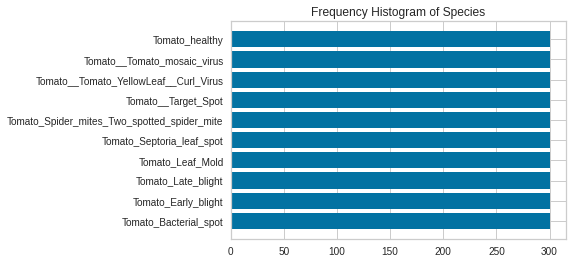

<Figure size 864x864 with 0 Axes>

In [ ]:
# Plot a histogram
plt.barh(disease_types, wdth)
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

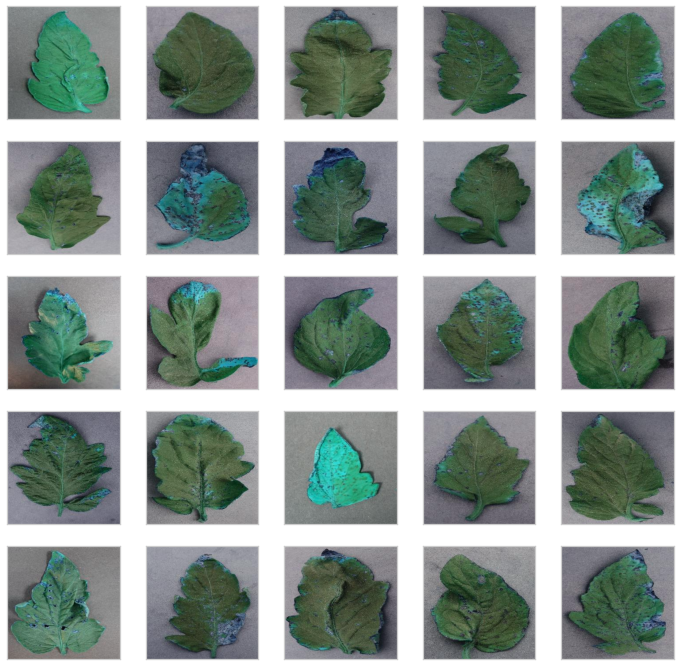

In [ ]:
# Display images for different species
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Tomato_Bacterial_spot', 5, 5)

In [ ]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))


0it [00:00, ?it/s]
33it [00:00, 325.91it/s]
57it [00:00, 290.23it/s]
81it [00:00, 272.16it/s]
108it [00:00, 269.95it/s]
141it [00:00, 284.04it/s]
173it [00:00, 291.81it/s]
205it [00:00, 298.68it/s]
234it [00:00, 294.03it/s]
264it [00:00, 295.26it/s]
293it [00:01, 282.98it/s]
321it [00:01, 275.82it/s]
352it [00:01, 284.93it/s]
384it [00:01, 292.31it/s]
416it [00:01, 297.61it/s]
448it [00:01, 301.56it/s]
479it [00:01, 269.49it/s]
507it [00:01, 269.63it/s]
535it [00:01, 263.41it/s]
563it [00:02, 265.91it/s]
591it [00:02, 269.47it/s]
619it [00:02, 269.52it/s]
650it [00:02, 279.47it/s]
682it [00:02, 289.08it/s]
712it [00:02, 286.52it/s]
742it [00:02, 290.38it/s]
772it [00:02, 281.22it/s]
802it [00:02, 285.73it/s]
831it [00:02, 281.50it/s]
861it [00:03, 286.34it/s]
891it [00:03, 290.24it/s]
921it [00:03, 292.82it/s]
952it [00:03, 295.95it/s]
984it [00:03, 300.27it/s]
1016it [00:03, 303.95it/s]
1047it [00:03, 300.30it/s]
1078it [00:03, 300.55it/s]
1109it [00:03, 294.34it/s]
1140it [00:03, 29

Train Shape: (3000, 64, 64, 3)


In [ ]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=10)

In [ ]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

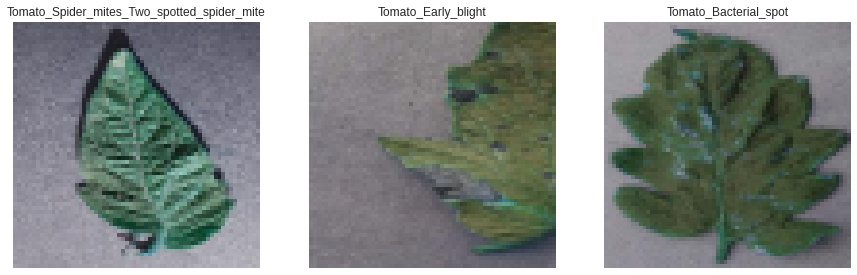

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 50
SIZE= 64
N_ch=3
IMAGE_SIZE = [100, 100]

In [ ]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)
    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(10,activation = 'softmax', name='root')(x)
 
    # model
    model = Model(input,output)
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', 'AUC'])
    model.summary()
    
    return model

In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

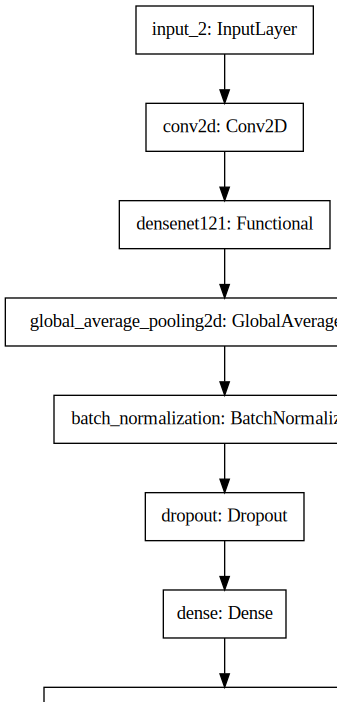

In [ ]:
SVG(model_to_dot(model).create(prog='dot',format='svg'))

Text(0.5, 145.31999999999996, 'Predicted')

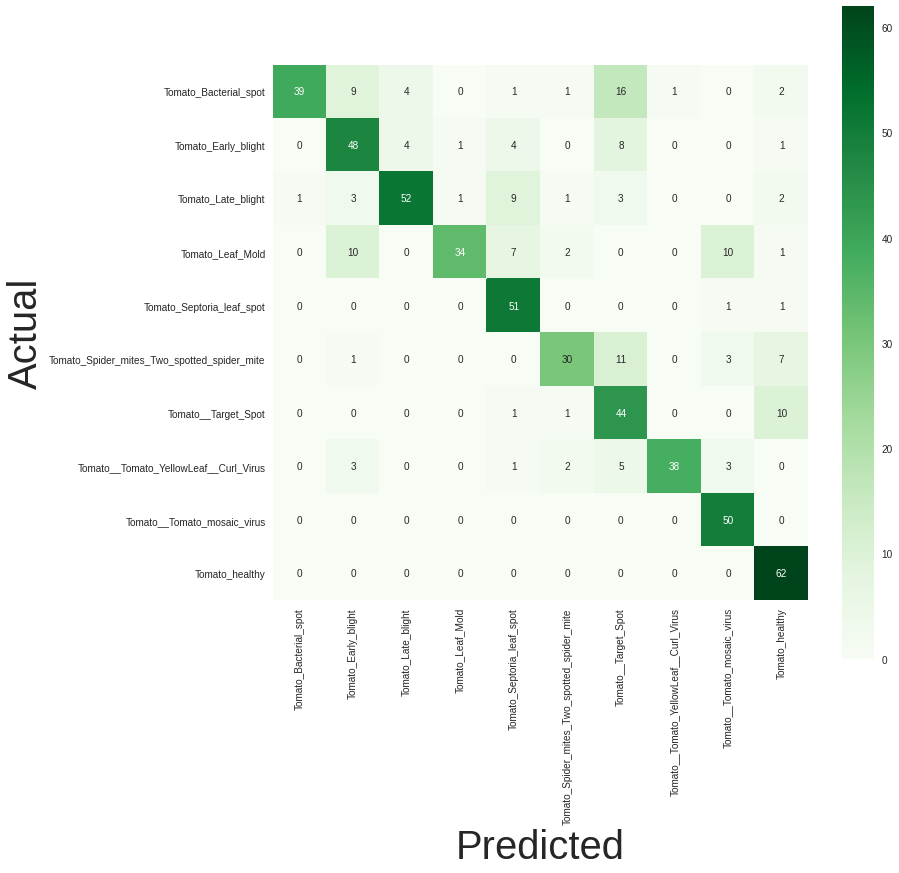

In [ ]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

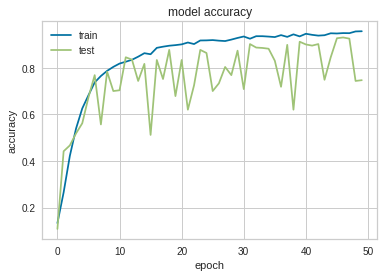

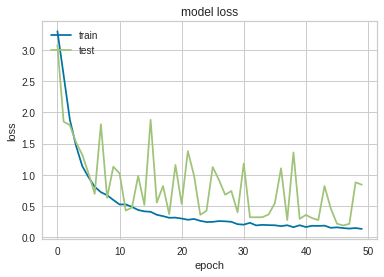

In [ ]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()  

In [ ]:
Y_pred = model.predict(X_val)
Y_pred

array([[9.0648417e-10, 2.6029626e-10, 5.6385701e-09, ..., 2.0570610e-09,
        9.9999988e-01, 1.0627519e-11],
       [2.4372762e-06, 3.6906897e-08, 7.2781390e-08, ..., 9.9950111e-01,
        4.6541149e-04, 4.7685344e-06],
       [4.8147655e-09, 5.2196834e-09, 5.8122895e-10, ..., 3.3075465e-09,
        9.9999654e-01, 6.5253829e-09],
       ...,
       [1.5868153e-07, 7.3134704e-10, 1.9705070e-08, ..., 1.7536678e-07,
        5.3829735e-05, 1.6110373e-07],
       [3.9700270e-04, 3.7177033e-05, 3.0410165e-05, ..., 5.3725933e-04,
        3.8728163e-02, 9.1747683e-01],
       [9.7231132e-06, 2.3735265e-05, 7.5025156e-07, ..., 1.4389082e-07,
        1.1597523e-05, 2.7307193e-05]], dtype=float32)

In [ ]:
n_classes = 10
lw=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


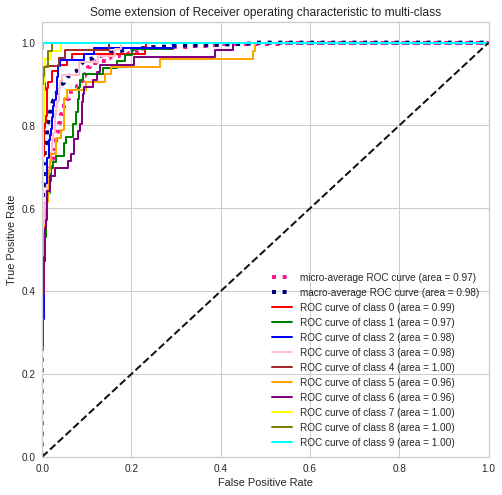

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'green', 'blue', 'pink', 'brown', 'orange', 'purple', 'yellow', 'olive', 'cyan'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

[4.3552450e-06 1.1210536e-04 5.6982529e-04 1.2186965e-03 3.1316507e-04
 4.6020564e-06 3.2151717e-04 2.7704643e-06 1.0841424e-04 9.9734455e-01]


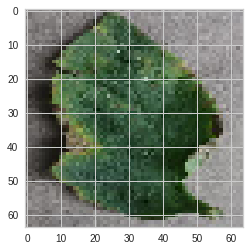

Prediction: Tomato_healthy


In [ ]:
img = image.load_img(data_dir+'Tomato_Bacterial_spot/f0256cb3-6072-453f-9230-2ab16c2db646___GCREC_Bact.Sp 6303.JPG', grayscale=False, target_size=(64, 64))
show_img=image.load_img(data_dir+'Tomato_Bacterial_spot/f0256cb3-6072-453f-9230-2ab16c2db646___GCREC_Bact.Sp 6303.JPG', grayscale=False, target_size=(64, 64))
disease_class = ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
#x = np.array(x, 'float32')
x /= 255

custom = model.predict(x)
print(custom[0])

#x = x.reshape([64, 64]);

#plt.gray()
plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])